# Programming Assignment

## Naive Bayes and logistic regression

### Instructions

In this notebook, you will write code to develop a Naive Bayes classifier model to the Iris dataset using Distribution objects from TensorFlow Probability. You will also explore the connection between the Naive Bayes classifier and logistic regression.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly.

### How to submit

Complete all the tasks you are asked for in the worksheet. When you have finished and are happy with your code, press the **Submit Assignment** button at the top of this notebook.

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell. If you would like to make further Tensorflow imports, you should add them here.

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import datasets, model_selection
%matplotlib inline

# If you would like to make further imports from TensorFlow or TensorFlow Probability, add them here




<tr>
<td><img src="data/iris_setosa.jpg" alt="Drawing" style="height: 270px;"/></td>
<td><img src="data/iris_versicolor.jpg" alt="Drawing" style="height: 270px;"/></td>
<td><img src="data/iris_virginica.jpg" alt="Drawing" style="height: 270px;"/></td>
</tr>

#### The Iris dataset

In this assignment, you will use the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html). It consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. For a reference, see the following papers:

- R. A. Fisher. "The use of multiple measurements in taxonomic problems". Annals of Eugenics. 7 (2): 179–188, 1936.

Your goal is to construct a Naive Bayes classifier model that predicts the correct class from the sepal length and sepal width features. Under certain assumptions about this classifier model, you will explore the relation to logistic regression.

#### Load and prepare the data

We will first read in the Iris dataset, and split the dataset into training and test sets. 

In [2]:
# Load the dataset

iris = datasets.load_iris()

In [3]:
# Use only the first two features: sepal length and width

data = iris.data[:, :2]
targets = iris.target

In [4]:
# Randomly shuffle the data and make train and test splits

x_train, x_test, y_train, y_test = model_selection.train_test_split(data, targets, test_size=0.2)

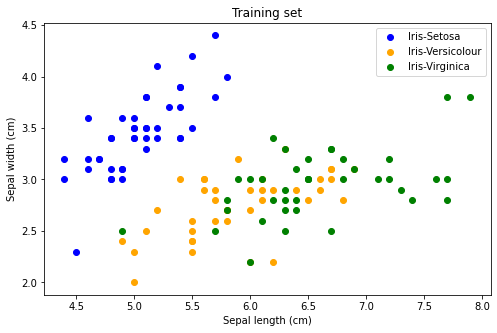

In [5]:
# Plot the training data

labels = {0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}
label_colours = ['blue', 'orange', 'green']

def plot_data(x, y, labels, colours):
    for c in np.unique(y):
        inx = np.where(y == c)
        plt.scatter(x[inx, 0], x[inx, 1], label=labels[c], c=colours[c])
    plt.title("Training set")
    plt.xlabel("Sepal length (cm)")
    plt.ylabel("Sepal width (cm)")
    plt.legend()
    
plt.figure(figsize=(8, 5))
plot_data(x_train, y_train, labels, label_colours)
plt.show()

### Naive Bayes classifier

We will briefly review the Naive Bayes classifier model. The fundamental equation for this classifier is Bayes' rule:

$$
P(Y=y_k | X_1,\ldots,X_d) = \frac{P(X_1,\ldots,X_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(X_1,\ldots,X_d | Y=y_k)P(Y=y_k)}
$$

In the above, $d$ is the number of features or dimensions in the inputs $X$ (in our case $d=2$), and $K$ is the number of classes (in our case $K=3$). The distribution $P(Y)$ is the class prior distribution, which is a discrete distribution over $K$ classes. The distribution $P(X | Y)$ is the class-conditional distribution over inputs.

The Naive Bayes classifier makes the assumption that the data features $X_i$ are conditionally independent give the class $Y$ (the 'naive' assumption). In this case, the class-conditional distribution decomposes as

$$
\begin{align}
P(X | Y=y_k) &= P(X_1,\ldots,X_d | Y=y_k)\\
&= \prod_{i=1}^d P(X_i | Y=y_k)
\end{align}
$$

This simplifying assumption means that we typically need to estimate far fewer parameters for each of the distributions $P(X_i | Y=y_k)$ instead of the full joint distribution $P(X | Y=y_k)$.

Once the class prior distribution and class-conditional densities are estimated, the Naive Bayes classifier model can then make a class prediction $\hat{Y}$ for a new data input $\tilde{X} := (\tilde{X}_1,\ldots,\tilde{X}_d)$ according to

$$
\begin{align}
\hat{Y} &= \text{argmax}_{y_k} P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d) \\
&= \text{argmax}_{y_k}\frac{P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}\\
&= \text{argmax}_{y_k} P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)
\end{align}
$$

#### Define the class prior distribution
 
We will begin by defining the class prior distribution. To do this we will simply take the maximum likelihood estimate, given by

$$
P(Y=y_k) = \frac{\sum_{n=1}^N \delta(Y^{(n)}=y_k)}{N},
$$

where the superscript $(n)$ indicates the $n$-th dataset example, $\delta(Y^{(n)}=y_k) = 1$ if $Y^{(n)}=y_k$ and 0 otherwise, and $N$ is the total number of examples in the dataset. The above is simply the proportion of data examples belonging to class $k$.

You should now write a function that builds the prior distribution from the training data, and returns it as a `Categorical` Distribution object.

* The input to your function `y` will be a numpy array of shape `(num_samples,)`
* The entries in `y` will be integer labels $k=0, 1,\ldots, K-1$
* Your function should build and return the prior distribution as a `Categorical` distribution object
  * The probabilities for this distribution will be a length-$K$ vector, with entries corresponding to $P(Y = y_k)$ for $k=0,1,\ldots,K-1$
  * Your function should work for any value of $K\ge 1$
  * This Distribution will have an empty batch shape and empty event shape

In [6]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_prior(y):
    """
    This function takes training labels as a numpy array y of shape (num_samples,) as an input.
    Your function should 
    This function should build a Categorical Distribution object with empty batch shape 
    and event shape, with the probability of each class given as above. 
    Your function should return the Distribution object.
    """
    n_classes = np.unique(y).shape[0]
    counts = np.zeros(n_classes)
    for c_k in range(n_classes):
        counts[c_k] = np.sum(np.where(y==c_k, 1, 0))
        priors = counts/np.sum(counts)
    dist = tfd.Categorical(probs=priors)
    return dist

In [7]:
# Run your function to get the prior

prior = get_prior(y_train)

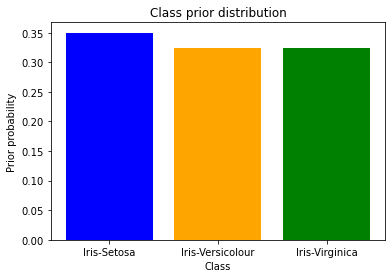

In [8]:
# Plot the prior distribution

labels = ['Iris-Setosa', 'Iris-Versicolour', 'Iris-Virginica']
plt.bar([0, 1, 2], prior.probs.numpy(), color=label_colours)
plt.xlabel("Class")
plt.ylabel("Prior probability")
plt.title("Class prior distribution")
plt.xticks([0, 1, 2], labels)
plt.show()

#### Define the class-conditional densities

We now turn to the definition of the class-conditional distributions $P(X_i | Y=y_k)$ for $i=0, 1$ and $k=0, 1, 2$. In our model, we will assume these distributions to be univariate Gaussian:

$$
\begin{align}
P(X_i | Y=y_k) &= N(X_i | \mu_{ik}, \sigma_{ik})\\
&= \frac{1}{\sqrt{2\pi\sigma_{ik}^2}} \exp\left\{-\frac{1}{2} \left(\frac{x - \mu_{ik}}{\sigma_{ik}}\right)^2\right\}
\end{align}
$$
with mean parameters $\mu_{ik}$ and standard deviation parameters $\sigma_{ik}$, twelve parameters in all. We will again estimate these parameters using maximum likelihood. In this case, the estimates are given by

$$
\begin{align}
\hat{\mu}_{ik} &= \frac{\sum_n X_i^{(n)} \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)} \\
\hat{\sigma}^2_{ik} &= \frac{\sum_n (X_i^{(n)} - \hat{\mu}_{ik})^2 \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)}
\end{align}
$$

Note that the above are just the means and variances of the sample data points for each class.

You should now write a function the computes the class-conditional Gaussian densities, using the maximum likelihood parameter estimates given above, and returns them in a single, batched `MultivariateNormalDiag` Distribution object. 

* The inputs to the function are 
  * a numpy array `x` of shape `(num_samples, num_features)` for the data inputs
  * a numpy array `y` of shape `(num_samples,)` for the target labels
* Your function should work for any number of classes $K\ge 1$ and any number of features $d\ge 1$

In [9]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_class_conditionals(x, y):
    """
    This function takes training data samples x and labels y as inputs.
    This function should build the class-conditional Gaussian distributions above. 
    It should construct a batch of distributions for each feature and each class, using the 
    parameter estimates above for the means and standard deviations.
    The batch shape of this distribution should be rank 2, where the first dimension corresponds
    to the number of classes and the second corresponds to the number of features.
    Your function should then return the Distribution object.
    """
    n_classes = np.unique(y).shape[0]
    n_features = x.shape[1]
    counts = np.zeros(n_classes)
    mean_feature_given_class = []
    std_feature_given_class = []
    for c_k in range(n_classes):
        mean_feature_given_class.append(np.mean(x[(y==c_k)], axis=0))
        std_feature_given_class.append(np.std(x[(y==c_k)], axis=0))

    class_cond = tfd.MultivariateNormalDiag(loc = np.asarray(mean_feature_given_class).reshape(n_classes, n_features),
                             scale_diag=np.asarray(std_feature_given_class).reshape(n_classes, n_features))
    
    return class_cond

In [10]:
# Run your function to get the class-conditional distributions

class_conditionals = get_class_conditionals(x_train, y_train)

We can visualise the class-conditional densities with contour plots by running the cell below. Notice how the contours of each distribution correspond to a Gaussian distribution with diagonal covariance matrix, since the model assumes that each feature is independent given the class.

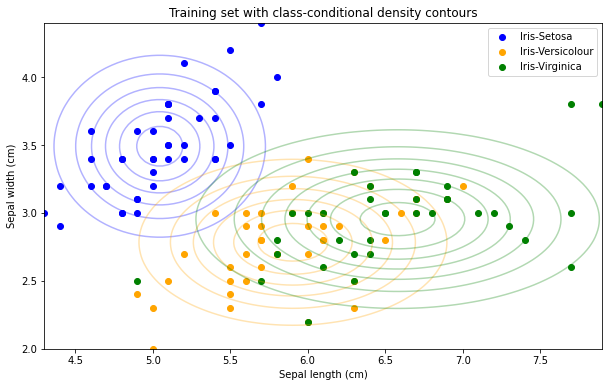

In [11]:
# Plot the training data with the class-conditional density contours

def get_meshgrid(x0_range, x1_range, num_points=100):
    x0 = np.linspace(x0_range[0], x0_range[1], num_points)
    x1 = np.linspace(x1_range[0], x1_range[1], num_points)
    return np.meshgrid(x0, x1)

def contour_plot(x0_range, x1_range, prob_fn, batch_shape, colours, levels=None, num_points=100):
    X0, X1 = get_meshgrid(x0_range, x1_range, num_points=num_points)
    Z = prob_fn(np.expand_dims(np.array([X0.ravel(), X1.ravel()]).T, 1))
    Z = np.array(Z).T.reshape(batch_shape, *X0.shape)
    for batch in np.arange(batch_shape):
        if levels:
            plt.contourf(X0, X1, Z[batch], alpha=0.2, colors=colours, levels=levels)
        else:
            plt.contour(X0, X1, Z[batch], colors=colours[batch], alpha=0.3)

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), class_conditionals.prob, 3, label_colours)
plt.title("Training set with class-conditional density contours")
plt.show()

#### Make predictions from the model

Now the prior and class-conditional distributions are defined, you can use them to compute the model's class probability predictions for an unknown test input $\tilde{X} = (\tilde{X}_1,\ldots,\tilde{X}_d)$, according to

$$
P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d) = \frac{P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}
$$

The class prediction can then be taken as the class with the maximum probability:

$$
\hat{Y} = \text{argmax}_{y_k} P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d)
$$

You should now write a function to return the model's class probabilities for a given batch of test inputs of shape `(batch_shape, 2)`, where the `batch_shape` has rank at least one. 

* The inputs to the function are the `prior` and `class_conditionals` distributions, and the inputs `x`
* Your function should use these distributions to compute the probabilities for each class $k$ as above
  * As before, your function should work for any number of classes $K\ge 1$
* It should then compute the prediction by taking the class with the highest probability
* The predictions should be returned in a numpy array of shape `(batch_shape)`

In [12]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def predict_class(prior, class_conditionals, x):
    """
    This function takes the prior distribution, class-conditional distribution, and 
    a batch of inputs in a numpy array of shape (batch_shape, 2).
    This function should compute the class probabilities for each input in the batch, using
    the prior and class-conditional distributions, according to the above equation.
    Note that the batch_shape of x could have rank higher than one!
    Your function should then return the class predictions by taking the class with the 
    maximum probability in a numpy array of shape (batch_shape,).
    """
    log_prob_list = []
    for sample in x:
        cond_probs = class_conditionals.log_prob(sample)
        joint_likelihood = tf.add(prior.probs.numpy(), cond_probs)
        norm_factor = tf.math.reduce_logsumexp(joint_likelihood, axis=-1, keepdims=True)
        log_prob = joint_likelihood - norm_factor
        log_prob_list.append(log_prob)
    return np.argmax(np.asarray(log_prob_list), axis=-1)

In [12]:
for sample in x_test:
    print(sample)

[5.8 2.7]
[6.4 3.2]
[5.1 3.8]
[5.7 2.8]
[5.  3.3]
[6.  3.4]
[7.  3.2]
[7.7 2.6]
[4.6 3.4]
[5.6 2.7]
[4.3 3. ]
[6.4 3.2]
[6.3 2.3]
[5.1 3.7]
[6.3 2.5]
[6.4 2.8]
[6.7 3.1]
[5.7 3. ]
[6.1 2.8]
[6.9 3.2]
[6.9 3.1]
[5.9 3. ]
[5. 3.]
[5.  3.2]
[4.4 2.9]
[7.2 3.6]
[6.7 3. ]
[5.6 2.8]
[5.6 2.5]
[6.3 3.4]


In [13]:
# Get the class predictions

predictions = predict_class(prior, class_conditionals, x_test)

In [14]:
# Evaluate the model accuracy on the test set

accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: {:.4f}".format(accuracy))

Test accuracy: 0.7000


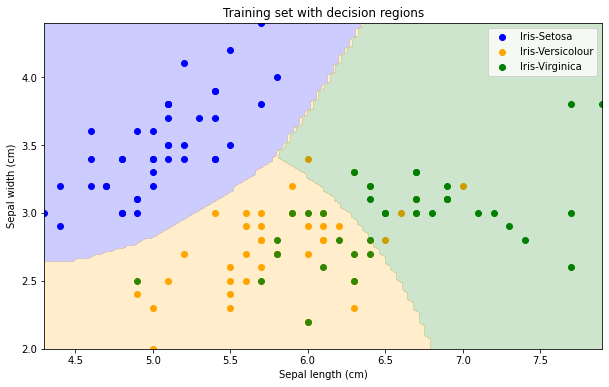

In [22]:
# Plot the model's decision regions

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
             lambda x: predict_class(prior, class_conditionals, x), 
             1, label_colours, levels=[-0.5, 0.5, 1.5, 2.5],
             num_points=100)
plt.title("Training set with decision regions")
plt.show()